# Twitter analysis of COVID-19

This notebook contains exploratory analyses of tweets published in relation to the COVID-19. Tweets that contain the keywords `coronavirus`, `covid-19`, `2019-nCoV`, and `covid19` were extracted using the python library [Get Old Tweets](https://pypi.org/project/GetOldTweets3/).

## Start dask dashboard

In [1]:
from dask.distributed import Client
#client = Client(n_workers=1, threads_per_worker=4, memory_limit='4GB')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:44157 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 16.69 GB


## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import networkx as nx
import dask.dataframe as dd
import os
import tldextract

from datetime import date
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Image

plt.style.use('seaborn')
pd.set_option('display.max_colwidth', None)

In [2]:
# Class to embed tweets
class Tweet(object):
    def __init__(self, embed_str=None):
        self.embed_str = embed_str

    def _repr_html_(self):
        return self.embed_str

## Load data

In [3]:
file_name = 'ours_2019-01-01_to_2020-02-22_coronavirus(es-en)_tweets.csv'

In [ ]:
# Define column types. Types were obtained from the optimization 
# operations defined in the notebook optimize_column_types
column_types = {'tweet_id': 'uint64', 'user_id': 'uint64', 'tweet': 'object', 'key': 'category', 
                'key_group': 'category', 'retweets': 'uint32', 'favorites': 'uint32', 'mentions': 'category', 
                'hashtags': 'category', 'geo': 'float32', 'urls': 'object', 'permalink': 'object', 
                'username': 'object', 'key_mention': 'category', 'key_group_mention': 'category', 
                'lang': 'category', 'tweet_length': 'uint16', 'tweet_word_count': 'uint8', 
                'hashtags_count': 'uint8', 'mentions_count': 'uint8'}

In [4]:
tweets = pd.read_csv('data/'+file_name, parse_dates=['date','formatted_date'])

In [6]:
print("Dataframe size:\nRows: {0:,}; Columns: {1}".format(tweets.shape[0], tweets.shape[1]))

Dataframe size:
Rows: 4,740,401; Columns: 22


## Process data

In [7]:
# remove columns that were used for the search
tweets = tweets.drop(['key', 'key_group', 'key_mention', 'key_group_mention', 'geo'], axis=1)

In [10]:
# rename columns
tweets = tweets.rename(columns={'date': 'datetime', 'formatted_date': 'formatted_datetime'})

In [11]:
tweets.head()

,tweet_id,user_id,tweet,datetime,formatted_datetime,retweets,favorites,mentions,hashtags,geo,urls,permalink,username,lang,tweet_length,tweet_word_count,hashtags_count,mentions_count
0,1220134080932696072,1057027456765452293,"The continuing 2019-nCoV epidemic threat of novel coronaviruses to global health - The latest 2019 novel coronavirus outbreak in Wuhan, China. Int J Infect Dis. Hui DS, et al. https://www. ncbi.nlm.nih.gov/m/pubmed/31953 166/ … #science #research pic.twitter.com/yCHZ7YsuUc",2020-01-23 01:00:08,2020-01-23 01:00:08+00:00,0,0,NaN,#science #research,NaN,https://www.ncbi.nlm.nih.gov/m/pubmed/31953166/,https://twitter.com/researchphilia/status/1220134080932696072,researchphilia,es,273,36,2,0
1,1220134674887892993,165080514,"BREAKING: The Wuhan #coronavirus most likely came from snakes, according to Journal of Medical Virology. #2019nCoV #WuhanCoronavirus #wuhanvirus https:// onlinelibrary.wiley.com/doi/abs/10.100 2/jmv.25682#.XiiKNB29vcU …",2020-01-23 01:02:30,2020-01-23 01:02:30+00:00,174,188,NaN,#coronavirus #2019nCoV #WuhanCoronavirus #wuhanvirus #,NaN,https://onlinelibrary.wiley.com/doi/abs/10.1002/jmv.25682#.XiiKNB29vcU,https://twitter.com/richardvolle/status/1220134674887892993,richardvolle,es,219,22,5,0
2,1220134704529190913,1102688399570452480,"Lo más correcto sería ponerle "" 2019-nCoV "", ya que los coronavirus son en realidad una familia de diversos virus que causan diversas enfermedades.",2020-01-23 01:02:37,2020-01-23 01:02:37+00:00,0,0,NaN,NaN,NaN,NaN,https://twitter.com/FauReyC/status/1220134704529190913,FauReyC,es,147,24,0,0
3,1220135328050184192,1663541358,No existe vacuna ni tratamiento disponible para este nuevo subtipo de virus; expertos emiten una serie de #recomendaciones por el #coronavirus 2019-nCoV . http:// ow.ly/2trt50y2pAa,2020-01-23 01:05:05,2020-01-23 01:05:05+00:00,0,0,NaN,#recomendaciones #coronavirus,NaN,http://ow.ly/2trt50y2pAa,https://twitter.com/QuadratinMexico/status/1220135328050184192,QuadratinMexico,es,180,25,2,0
4,1220135597320409089,223226324,New analysis on @biorxivpreprint from Michael Letko and Vincent Munster @NIH . #2019nCoV uses the ACE2 receptor. https://www. biorxiv.org/content/10.110 1/2020.01.22.915660v1 …,2020-01-23 01:06:10,2020-01-23 01:06:10+00:00,3,6,@biorxivpreprint @NIH,#2019nCoV,NaN,https://www.biorxiv.org/content/10.1101/2020.01.22.915660v1,https://twitter.com/nycbat/status/1220135597320409089,nycbat,es,176,21,1,2


In [12]:
# remove empty rows
tweets.dropna();

In [10]:
print("Dataframe size:\nRows: {0:,}; Columns: {1}".format(tweets.shape[0].compute(), tweets.shape[1]))

Dataframe size:
Rows: 4,740,401; Columns: 18


In [13]:
# remove duplicates
unique_tweet_ids = tweets.tweet_id.unique()
tweets = tweets.drop_duplicates(subset='tweet_id', keep='first') 

In [ ]:
num_rows = tweets.shape[0].compute()
assert num_rows==len(unique_tweet_ids), 'Drop duplicate operation failed!'
unique_tweet_ids = None

In [13]:
# create a date colum
tweets['date'] = tweets.loc[:,'formatted_datetime'].dt.date

Filter out tweets that are older than 31st December 2019, date of the [first reported case](https://www.who.int/emergencies/diseases/novel-coronavirus-2019) of coronavirus

In [14]:
start_date = date(2019, 12, 31)
start_date = pd.to_datetime(start_date, utc=False)
tweets = tweets[tweets['date'] >= start_date]

In [15]:
print('NUm. Tweets: {0:,}'.format(tweets.shape[0]))

NUm. Tweets: 4,718,654


---
## Evolution of tweets over time

In [17]:
# group tweets by date
tweets_by_date = 

In [ ]:
tweets.groupby('date', as_index=False).count()

In [ ]:
plt.figure(figsize=(18,8))
x_dates = [date.strftime('%d-%m-%Y') for date in np.sort(tweets['date'].unique())]
y_counts = list(tweets.groupby('date', as_index=False).count())
fig = sns.lineplot(x_dates, y_counts, color='blue', sort=False)
fig.set(xlabel='Fecha', ylabel='Tweets')
sns.set_style("dark", {'axes.grid': True})
fig.set_xticklabels(labels=x_dates, rotation=90)
plt.fill_between(x_dates, y_counts, alpha=0.5, color='blue')
plt.show()
x_dates, y_counts = None, None
#fig.get_figure().savefig("tweets_over_time.png", dpi=200, quality=95, bbox_inches="tight")

#### Let's explore what happened on the 21-01-2020 that raised the interested on the topic

In [19]:
start_date = pd.to_datetime(date(2020, 1, 21), utc=False)

In [20]:
print('Num. Tweets: {0:,}'.format(tweets[(tweets['date'] >= start_date)].shape[0]))

Num. Tweets: 4,691,091


In [21]:
print('{}% of all tweets were generated during this period'.format(
      round(100*tweets[(tweets['date'] >= start_date)].shape[0]/tweets.shape[0], 0)))

99.0% of all tweets were generated during this period


In [22]:
# get hour of tweets
tweets.loc[:,'date_hour'] = tweets.loc[:,'formatted_datetime'].dt.strftime('%d-%m-%Y %H')

In [ ]:
# group tweets by date and hour
tweets_bulk_period_by_date_hour = tweets[(tweets['date'] >= start_date)].groupby('date_hour').count()

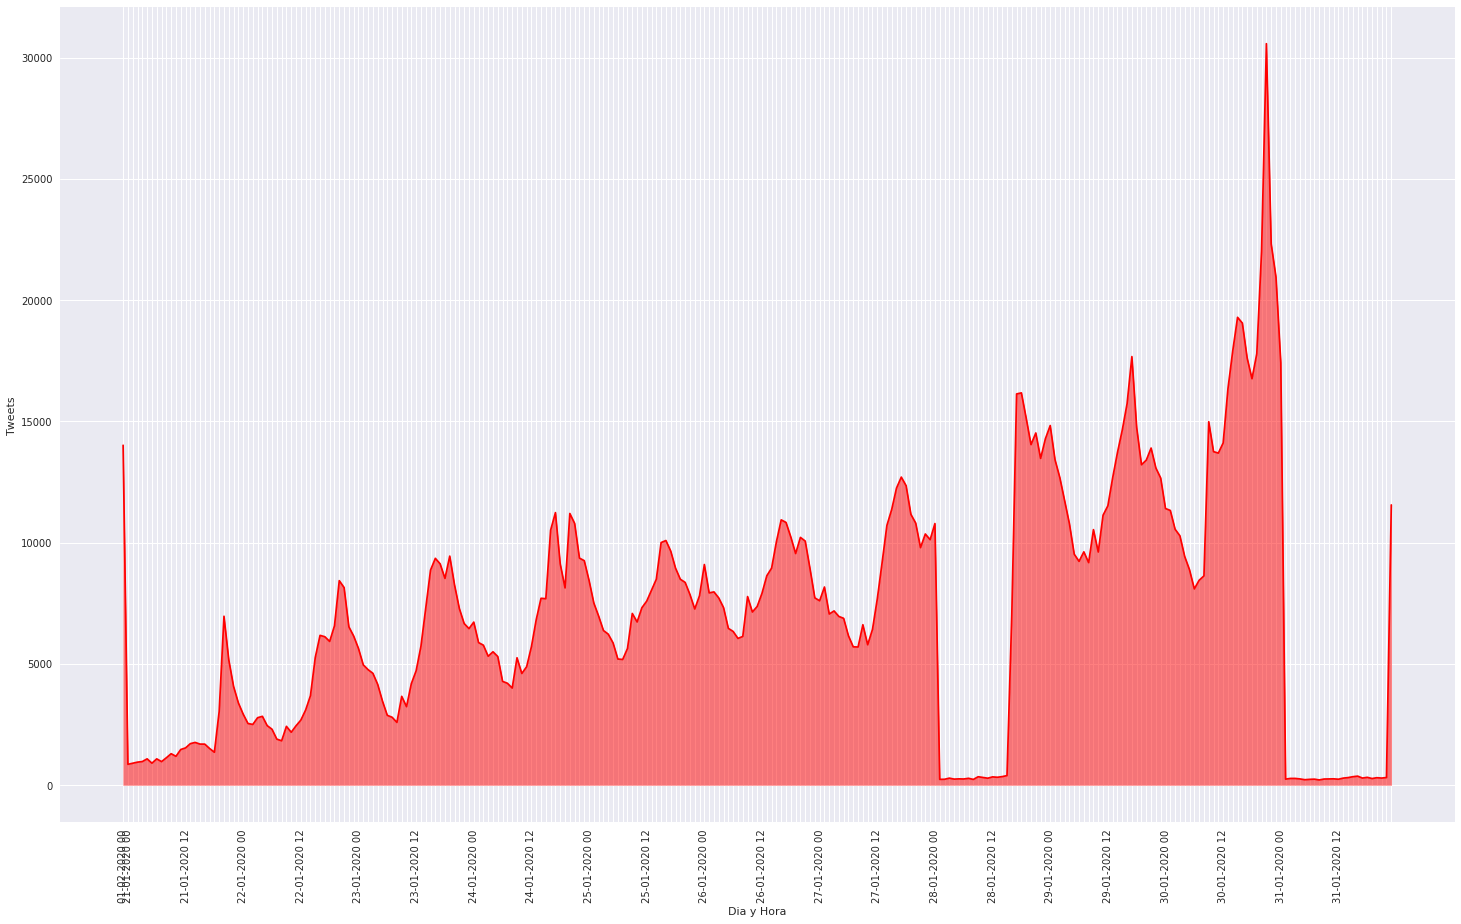

In [85]:
plt.figure(figsize=(25,15))
x_dates = list(tweets_bulk_period_by_date_hour.index)
y_counts = list(tweets_bulk_period_by_date_hour['tweet_id'])
fig = sns.lineplot(x=x_dates, y=y_counts, color='red')
fig.set(xlabel='Dia y Hora', ylabel='Tweets')
sns.set_style('dark', {'axes.grid': True})
fig.set_xticklabels(labels=x_dates, rotation=90)
labels = fig.get_xticklabels() # get x labels
for i, l in enumerate(labels):
    if '00' not in str(labels[i]) and \
       '12' not in str(labels[i]):
        labels[i] = '' # skip labels
fig.set_xticklabels(labels, rotation=90)
plt.fill_between(x_dates, y_counts, alpha=0.5, color='red')
plt.show()

In [89]:
tweets[(tweets['date'] == start_date)][['username', 'date', 'tweet']].head(10)

,username,date,tweet
18768,jessicadavis_,2020-01-21,Check out our preliminary assessment of the international spreading risk of 2019 nCOV . https://www. mobs-lab.org/2019ncov.html pic.twitter.com/jmdvBGnwRm
18769,orpnoticias,2020-01-21,"#INTERNACIONAL Van 228 casos de coronavirus en China y otros países China reportó hoy 228 casos de neumonía causada por el coronavirus 2019-nCoV , que surgió a fines de diciembre pasado en la central ciudad de Wuhan, pic.twitter.com/PSqPrrKRGC"
18770,Korrektheiten,2020-01-21,"MMNews: 2019-nCoV : Neues Virus in China - WHO beruft Notfallausschuss ein: Nachdem eine neuartiges Coronavirus mit der Bezeichnung 2019-nCoV in China über 200 Lungenerkrankungen verursacht und drei Todesfälle gefordert hat, beruft die… http:// dlvr.it/RNQYBX"
18771,PonchoMunoz,2020-01-21,El Director @DrTedros de la @WHO convoca a reunión URGENTE sobre el #coronavirus ( 2019-nCoV ) y evaluar si constituye una emergencia de salud pública de preocupación internacional y qué recomendaciones se deben hacer para manejar el brote. pic.twitter.com/T4EYFAaSee
18772,TheBigApple13,2020-01-21,"2019-nCoV isimli SARS2 olarak da adlandırılan virüse yönelik ""containment"" çabaları başarısız olmuş gözüküyor. Çin'de hızla yayılmakta olan virüsün 260+ onaylanmış vakada 4 can aldığı belirtilmekte. Japonya, Thailand ve Güney Kore'de vakalar gözlemleniyor. Çok tehlikeli bir durum"
18773,ThaiPBSNews,2020-01-21,โลกกังวลการแพร่ระบาดของไวรัสโคโรนาสายพันธุ์ใหม่ ( 2019-nCoV ) ล่าสุดผู้ติดเชื้อไวรัสในจีนพุ่งสูง 130 คน https:// news.thaipbs.or.th/content/288146 #ThaiPBSnews
18774,officialbiolar,2020-01-21,"known as the Wuhan virus, or 2019-nCoV in china and other countries of the world are already on red alert which I am sure Nigeria is yet to be aware of or take any action about. Nigeria Imports from China was US$8.35 Billion during 2018, according to the UN"
18775,InfidelWarrior0,2020-01-21,"Wuhan, China Novel Coronavirus ( 2019-nCoV ) spreading w/ at least 230 cases incl 14 med staff, 4 deaths, human to human transmission. AlertsUSA monitoring.."
18776,CryptoJ0ules,2020-01-21,When you think you have the flu but you really have #coronavirus #2019-nCoV #SARS2 https:// twitter.com/Bleeding_Crypt o/status/1218974729115013120 …
18777,Krranco,2020-01-21,"los casos de coronavirus en china #2019-nCoV aumentan, las autoridades admiten transmisión de humano a humano pic.twitter.com/I9fl0kvhdM"


It might happened that the urgent meeting organized by WHO raised interests worldwide about the disease.

---

## Tweet Authors

In [90]:
tweets_by_author = tweets.groupby('username')

In [91]:
total_authors = len(tweets_by_author.groups)

In [93]:
print('There are {0:,} Twitter users that have posted tweets about coronavirus'.format(total_authors))

There are 936,124 Twitter users that have posted tweets about coronavirus


#### Top-50 most active authors

In [97]:
tweets_authors_count = tweets_by_author.count()

In [98]:
tweets_authors_count.sort_values('tweet_id', ascending=False).head(50).index

Index(['r__worldnews', 'AndyVermaut', 'contrapuntovzla', 'poandpo',
       'ZyroFoxtrot', 'ElNacionalWeb', 'PneumoniaWuhan', 'AnalyticaGlobal',
       'la_patilla', 'EcoInternetDrGB', 'TheArticleTrunk', 'noticiasdelmun4',
       'mlnangalama', 'infoitsalute', '24sante_fr', 'dev_discourse',
       'News247WorldPre', 'SuNoticiero', 'JCSura', 'k29664911', '4PawShop',
       'peruenlanoticia', 'BaronianConsult', 'twosheeep1', 'marciojmsilva',
       'TPE_connect', 'El_Cooperante', 'TheTop10News2', 'infoitestero',
       'threadreaderapp', 'FreieWeltEu', 'zazoomnews', 'wotonews',
       'VIKBataille', 'raybae689', 'Apex_WW', 'EP_Mundo', 'venezuelaaldia',
       'HernanPorrasM', 'cnnphilippines', 'zazoomblog', 'crewislife',
       'CaraotaDigital', 'PulpNews', 'marketprdaily', 'DolarToday',
       'StrategicNews2', 'En24_News', 'ABSCBNNews', 'coolsandy8800'],
      dtype='object', name='username')

In [99]:
active_authors = list(tweets_authors_count.sort_values('tweet_id', ascending=False).head(50)['tweet_id'].index)
active_authors_tweets = list(tweets_authors_count.sort_values('tweet_id', ascending=False).head(50)['tweet_id'])

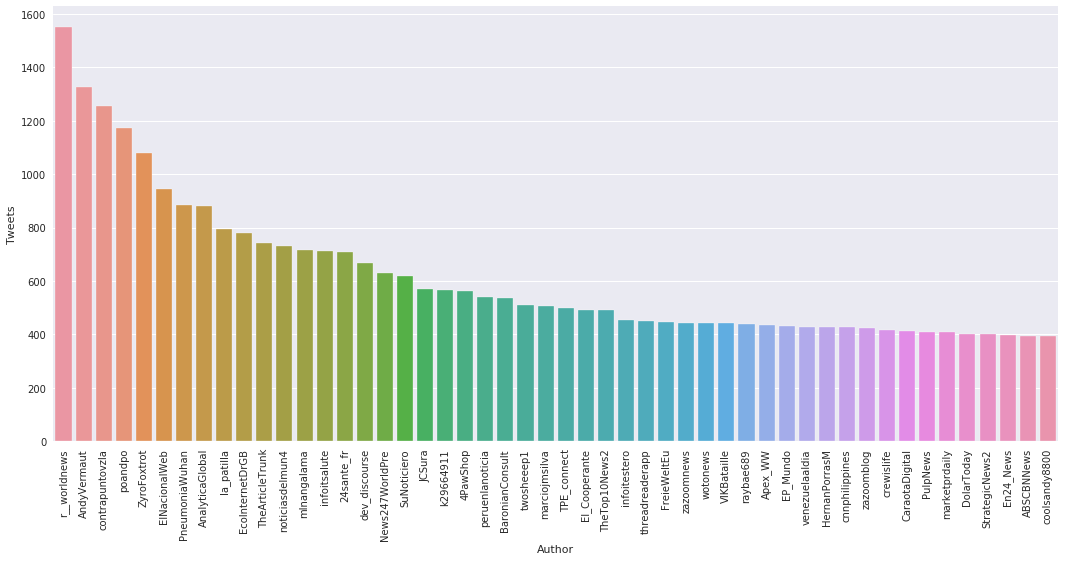

In [100]:
plt.figure(figsize=(18,8))
fig = sns.barplot(x=active_authors, y=active_authors_tweets)
fig.set(xlabel='Author', ylabel='Tweets')
fig.set_xticklabels(labels=active_authors, rotation=90)
plt.show()

The majority of the most active users are profile that do not belong to large mass-media communication agencies. The most active user is [@r__worldnews](https://twitter.com/r__worldnews) a unofficial account of the reedit social network. The second most active [@AndyVermaut](https://twitter.com/AndyVermaut) corresponds to a human-rights activists while the third one [@contrapuntovzla](https://twitter.com/contrapuntovzla) is associated to an independent online newspaper.

#### Most mentioned users

In [101]:
tweets_with_mentions = tweets[~tweets['mentions'].isna()]

In [103]:
print('There are {0:,} tweets with mentions in the text'.format(tweets_with_mentions.shape[0]))

There are 237,471 tweets with mentions in the text


In [104]:
user_mentions = defaultdict(int)
for index, tweet in tweets_with_mentions.iterrows():
    mentions = tweet['mentions'].split()
    for mention in mentions:
        user_mentions[mention] += 1

In [105]:
user_mentions_df = pd.DataFrame.from_dict({'username': list(user_mentions.keys()), 
                                           'mention_count': list(user_mentions.values())})

In [106]:
# remove @ mention because there cannot be an user with @ as username
user_mentions_df = user_mentions_df[user_mentions_df['username']!='@']

Top-10 most mentioned users

In [107]:
# show the top-10 most mentioned users
user_mentions_df.sort_values('mention_count', ascending=False).head(10)

,username,mention_count
100,@YouTube,22896
7,@WHO,9495
994,@MailOnline,3849
15,@CDCgov,3634
325,@realDonaldTrump,3533
990,@GoogleNews,2664
648,@scmpnews,1504
2072,@nypost,1351
6004,@gatewaypundit,1305
8,@DrTedros,1189


Top-50 most mentioned users

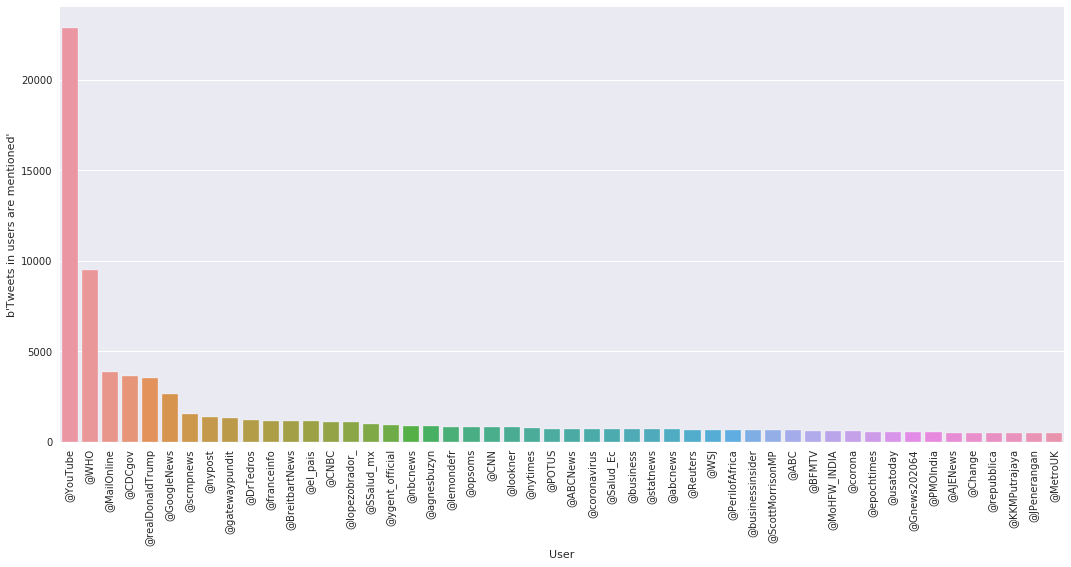

In [108]:
plt.figure(figsize=(18,8))
mentioned_users = list(user_mentions_df.sort_values('mention_count', ascending=False).head(50)['username'])
mentions_count = list(user_mentions_df.sort_values('mention_count', ascending=False).head(50)['mention_count'])
fig = sns.barplot(x=mentioned_users, y=mentions_count)
fig.set(xlabel='User', ylabel=b'Tweets in users are mentioned')
fig.set_xticklabels(labels=mentioned_users, rotation=90)
plt.show()

The most mentioned account by far is [@Youtube](https://twitter.com/Youtube) indicating the high-prevalence of video materials shared in relation to the topic.

#### Tweets that mention surprised users (e.g., @YouTube, @realDonaldTrump)

Tweets that mention **`@Youtube`**

In [109]:
tweets[tweets['mentions'].isin(['@YouTube'])][['tweet_id', 'username', 'tweet', 'datetime', 'urls', 'retweets']].sort_values('retweets', ascending=False).head(10)

,tweet_id,username,tweet,datetime,urls,retweets
767064,1221909342632341504,inthecopa,Inside Wuhan: Daily life in China's coronavirus quarantine zone A must watch. A citizen gets ready to take walk in Wuhan. The precautions he takes... https:// youtu.be/luztqxUBvZo via @YouTube,2020-01-27 22:34:23,https://youtu.be/luztqxUBvZo,230
936975,1221499394647703552,Ginalolaknits,International Pressure is Needed NOW PLEASE RT and spread this Plea for Help Wuhan citizen plainly tells the #coronavirus situation in Wuhan & seeks ... https:// youtu.be/7OEqybiGdaA via @YouTube,2020-01-26 19:25:24,https://youtu.be/7OEqybiGdaA,227
1267319,1222832297432403969,heart021485,Coronavirus : Doctor explains the proper way to wash your hands and put o... https:// youtu.be/A4qwCWwC-Oo via @YouTube,2020-01-30 11:41:53,https://youtu.be/A4qwCWwC-Oo,165
1820272,1222203834434408448,sonkoubun,コロナウイルスでバタッと倒れた人たちまとめ。武漢、上海、香港。 https:// youtu.be/RfVr_vQ3-cQ @YouTube さんから #コロナウイルス #Coronavirus #武漢新型肺炎,2020-01-28 18:04:36,https://youtu.be/RfVr_vQ3-cQ,147
8669,1222902972218105860,Tanya4367,Kindly share this video for public awareness and guidelines! Be safe everyone! Novel Coronavirus ( 2019-nCoV ) OUTBREAK PREVENTION AWARENESS! https:// youtu.be/b67YKDjvII8 via @YouTube,2020-01-30 16:22:43,https://youtu.be/b67YKDjvII8,135
750328,1221883398098079744,Ggoodgirlsfirst,Coronavirus : 2030 U.N. Agenda does not differentiate between left and right! Please watch: The Globalists' must be stopped!!! The TRUTH About Coronavirus & Our Fragile Civilization https:// youtu.be/7ld1tF9GeXc via @YouTube,2020-01-27 20:51:18,https://youtu.be/7ld1tF9GeXc,96
1179990,1222703821572325378,sonkoubun,情報量が大きくて、シェイプアップして伝えます！観てください。 コロナウイルス、中国、世界の情報、1月30日のまとめ。 #Coronavirus https:// youtu.be/RRMFJj5wuGQ @YouTube さんから #コロナウイルス,2020-01-30 03:11:22,https://youtu.be/RRMFJj5wuGQ,89
979207,1221570245476995072,OsmarTerra,ATENÇÃO : Saiba mais sobre o novo coronavírus https:// youtu.be/5YkDJV5NjDY via @YouTube,2020-01-27 00:06:56,https://youtu.be/5YkDJV5NjDY,66
555715,1221000608397742081,neuro7plastic,Chinese Coronavirus: What to Know & What to Do ( 2019-nCoV ) https:// youtu.be/QA5AbqlCHuc via @YouTube,2020-01-25 10:23:24,https://youtu.be/QA5AbqlCHuc,65
1762261,1221167144844627976,CoreysDigs,"Dig It! #31: Coronavirus , Puerto Rico Scandal, 2A in VA, Bernie Campaign... https:// youtu.be/qOrNGSydYRU via @YouTube",2020-01-25 21:25:10,https://youtu.be/qOrNGSydYRU,63


They are primarily videos posted through the Youtube's sharing function. The most retweeted one is shown below.

In [110]:
tweet_html = ("""
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Inside Wuhan: Daily life in China&#39;s coronavirus quarantine zone <br><br>A must watch. A citizen gets ready to take walk in Wuhan. The precautions he takes...<a href="https://t.co/iARuzb2QKT">https://t.co/iARuzb2QKT</a> via <a href="https://twitter.com/YouTube?ref_src=twsrc%5Etfw">@YouTube</a></p>&mdash; Myrna 🇺🇸 ⭐️⭐️⭐️ 🇺🇸 (@inthecopa) <a href="https://twitter.com/inthecopa/status/1221909342632341504?ref_src=twsrc%5Etfw">January 27, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
""")
Tweet(tweet_html)

Tweets that mention **`@realDonaldTrump`**

In [111]:
tweets[tweets['mentions'].isin(['@realDonaldTrump'])][['tweet_id', 'username', 'tweet', 'datetime', 'retweets']].sort_values('retweets', ascending=False).head(10)

,tweet_id,username,tweet,datetime,retweets
890546,1221429746803838977,TomFitton,"URGENT: @realDonaldTrump should presume bureaucratic incompetence (or worse) and light a fire under CDC, State, HHS, and DHS on #Coronavirus . Governors and state officials also need to get on the ball. https:// twitter.com/KTLA/status/12 21337255731593216 …",2020-01-26 14:48:39,1189
1500611,1223019554047029248,no_silenced,JUST IN: Italy is stopping all air traffic to and from China in an effort to halt the spread of the coronavirus Great Move....Come on President Trump....Follow their lead!!! @realDonaldTrump,2020-01-31 00:05:58,737
1107357,1220788311654043648,CaslerNoel,We now have to take the word of a POTUS regarding coronavirus that it’s “totally under control” this was the guy that thought 34 service members who suffered traumatic brain injuries after a rocket attack just “had headaches” @realDonaldTrump,2020-01-24 20:19:49,708
1421516,1222970220576460805,XArmandKleinX,@realDonaldTrump Just received a briefing on the Coronavirus in China from all of our Great agencies who are also working closely with China.We will continue to monitor the ongoing developments.We have the best experts anywhere in the World and they are on top of it 24/7 pic.twitter.com/M8avPWkDlE,2020-01-30 20:49:56,224
926541,1221482894109167616,RealGsPatton007,"BIG VIRUS NEWS FROM CHINA Doctor says Chinese Government is lying 2 world about severity of Coronavirus . Says 100k+ infected & are dying daily. DON’T trust Govs Govs are Destroyers of Humanity esp Commie, Progressive Govs @realDonaldTrump is GOOD pic.twitter.com/I3JzEQhRkq",2020-01-26 18:19:50,188
944842,1221511695316799489,CaslerNoel,I’m sure Alex Azar will be under pressure from Trump not to declare an emergency re: coronavirus outbreak since the new cases are in California. @realDonaldTrump,2020-01-26 20:14:17,144
1638473,1220917117521997829,MBNRox,Its time to Declare a Global Emergency @realDonaldTrump China’s Coronavirus Keeps Spreading but the World Health Organization Still Won’t Declare a Global Emergency https://www. thedailybeast.com/chinas-coronav irus-keeps-spreading-but-the-world-health-organization-still-wont-declare-a-global-emergency …,2020-01-25 04:51:39,115
1149989,1220853713654501376,baskebabiko,@realDonaldTrump coronavirus mücadelesi için Çin'i överken altta Wuhan 'da 1000' den fazla ABD vatandaşı ile kendi ailesi bulunan kadın yardım istiyor. Ve soruyor 'onları ölüme mi yer ediyorsunuz?' pic.twitter.com/rVzlWyAkOz,2020-01-25 00:39:42,109
377088,1223374931808919554,NetworksManager,"#CoronaVirus declared emergency in US! President of United States, @realDonaldTrump signed a proclamation declaring any foreign nationals, other than immediate family of US citizens+permanent residents who traveled in China last 14 days are denied entry. pic.twitter.com/azC9mYJXdL",2020-01-31 23:38:07,105
534914,1220488147248861190,paulftheophilus,"President @realDonaldTrump - close down the flights from Wuhan Coronavirus infected areas right now, before it is to late! I believe drastic preventive measures must be taken. Better to be safe than sorry. https:// twitter.com/realDonaldTrum p/status/518552645414690816 … pic.twitter.com/HwdKaDtj5Y",2020-01-24 00:27:04,90


In [112]:
tweet_html = ("""
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">URGENT: <a href="https://twitter.com/realDonaldTrump?ref_src=twsrc%5Etfw">@realDonaldTrump</a> should presume bureaucratic incompetence (or worse) and light a fire under CDC, State, HHS, and DHS on <a href="https://twitter.com/hashtag/Coronavirus?src=hash&amp;ref_src=twsrc%5Etfw">#Coronavirus</a>. Governors and state officials also need to get on the ball. <a href="https://t.co/fvLg0JhJUN">https://t.co/fvLg0JhJUN</a></p>&mdash; Tom Fitton (@TomFitton) <a href="https://twitter.com/TomFitton/status/1221429746803838977?ref_src=twsrc%5Etfw">January 26, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
"""
)
Tweet(tweet_html)

#### Most retweeted authors

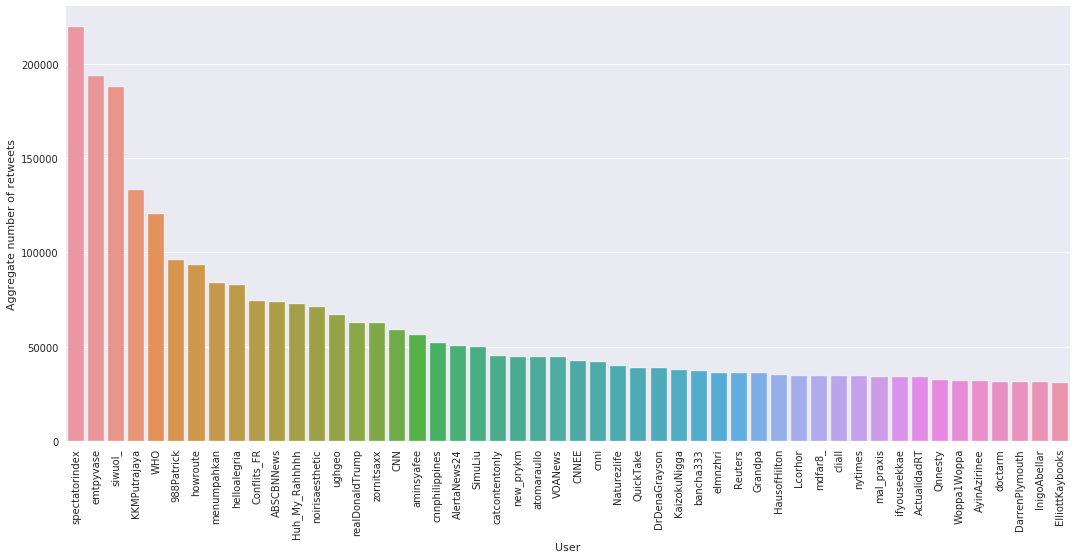

In [113]:
plt.figure(figsize=(18,8))
most_rt_users = list(tweets_by_author[['retweets']].sum().sort_values('retweets', ascending=False).head(50).index)
rts_count = list(tweets_by_author[['retweets']].sum().sort_values('retweets', ascending=False).head(50)['retweets'])
fig = sns.barplot(x=most_rt_users, y=rts_count)
fig.set(xlabel='User', ylabel='Aggregate number of retweets')
fig.set_xticklabels(labels=most_rt_users, rotation=90)
plt.show()

The most retweet tweet of the most retweeted author

In [122]:
tweet_html = ("""
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">2020:<br><br>- US killing Soleimani and Iran retaliation<br><br>- Iran downs Ukrainian plane<br><br>- Trump impeachment<br><br>- Russian PM resigns<br><br>- New strand of coronavirus<br><br>- Philippines volcano eruption<br><br>- Turkey earthquake<br><br>- Kashmir avalanche<br><br>- Australian fires<br><br>- Indonesia floods<br><br>- Kobe dead</p>&mdash; The Spectator Index (@spectatorindex) <a href="https://twitter.com/spectatorindex/status/1221537133254463490?ref_src=twsrc%5Etfw">January 26, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
"""
)
Tweet(tweet_html)

#### Most liked authors

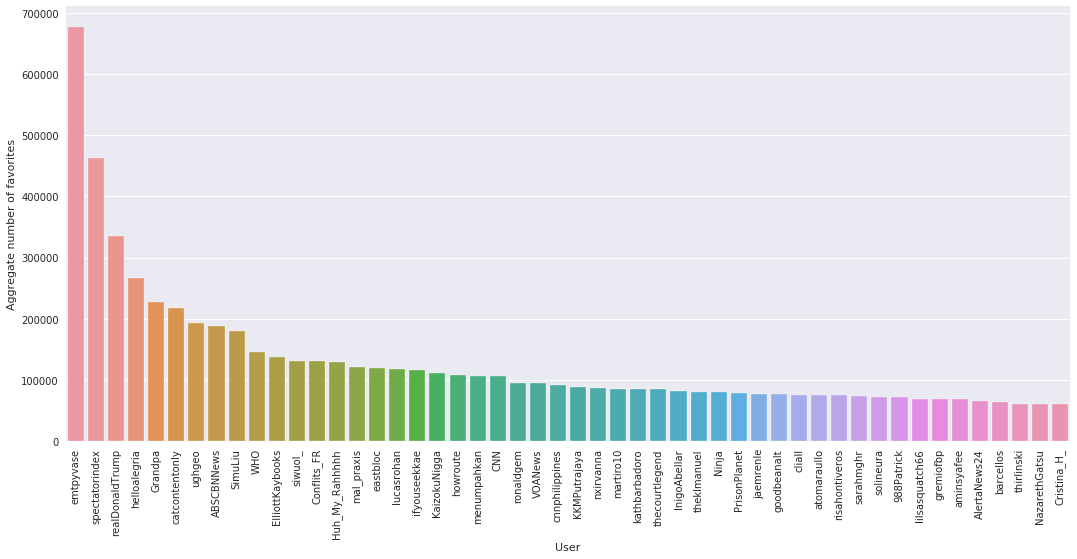

In [114]:
plt.figure(figsize=(18,8))
most_fav_users = list(tweets_by_author[['favorites']].sum().sort_values('favorites', ascending=False).head(50).index)
favs_count = list(tweets_by_author[['favorites']].sum().sort_values('favorites', ascending=False).head(50)['favorites'])
fig = sns.barplot(x=most_fav_users, y=favs_count)
fig.set(xlabel='User', ylabel='Aggregate number of favorites')
fig.set_xticklabels(labels=most_fav_users, rotation=90)
plt.show()

The most liked tweet of the most liked author

In [124]:
tweet_html = ("""
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">someone said “this is what happened when rats heard about the corona virus they dont wanna take the blame again” LMAOOOOOO <a href="https://t.co/9yQs9bcfuw">pic.twitter.com/9yQs9bcfuw</a></p>&mdash; night owl (@emtpyvase) <a href="https://twitter.com/emtpyvase/status/1221856224712495104?ref_src=twsrc%5Etfw">January 27, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
"""
)
Tweet(tweet_html)

#### Network of interactions

A network of interactions will be built to study how Twitter users interact between each other. Nodes in the network are users that appear in conversations about coronavirus as either authors or mentioned in tweets.

In [150]:
users_df = user_mentions_df
users_df['username'] = users_df['username'].str.replace('@','')
users_df = users_df.rename(columns={'mention_count': 'mentions'})

In [151]:
user_tweets_df = pd.DataFrame.from_dict({'username': tweets_authors_count.index,
                                         'tweets': tweets_authors_count['tweet_id']})
user_tweets_df.index = np.arange(user_tweets_df.shape[0])

In [152]:
users_df = pd.merge(users_df, user_tweets_df, on='username', how='outer')

In [153]:
users_df = users_df.fillna(0)

In [154]:
users_df.sort_values('mentions', ascending=False).head()

,username,mentions,tweets
100,YouTube,22896.0,1.0
7,WHO,9495.0,235.0
993,MailOnline,3849.0,183.0
15,CDCgov,3634.0,25.0
324,realDonaldTrump,3533.0,3.0


In [155]:
# compute interactions
interactions_given = defaultdict(set)
interactions_received = defaultdict(set)
for index, tweet in tweets_with_mentions.iterrows():
    mentions = tweet['mentions'].split()
    user = tweet['username']
    user = user.replace('@','')
    for mention in mentions:
        mention = mention.replace('@','')
        interactions_given[user].add(mention)
        interactions_received[mention].add(user)

In [156]:
def compute_interaction_string(user, interaction_dict):
    if user['username'] in interaction_dict.keys():
        return ' '.join(interaction_dict[user['username']])
    else:
        return np.nan

In [157]:
users_df['interactions_in'] = users_df.apply(compute_interaction_string, args=[interactions_received], 
                                                   axis=1)

In [158]:
users_df['interactions_out'] = users_df.apply(compute_interaction_string, args=[interactions_given], axis=1)

In [159]:
def compute_total_interactions(user, inter_key):
    if isinstance(user[inter_key], float):
        # it is nan
        return 0
    else:
        return len(user[inter_key].split())

In [160]:
users_df['total_interactions_in'] = users_df.apply(compute_total_interactions, args=['interactions_in'], axis=1) 

In [161]:
users_df['total_interactions_out'] = users_df.apply(compute_total_interactions, args=['interactions_out'], axis=1)

#### Users ordered by the number of unique mentions given

In [163]:
users_df.sort_values('total_interactions_out', ascending=False).head(1)

,username,mentions,tweets,interactions_in,interactions_out,total_interactions_in,total_interactions_out
781887,makoto_au_japon,0.0,342.0,NaN,smh KyivPost euronews cnnhealth BBCWorld SciencePresse japantimes DailyNews_lk UrduPointEng ncla1ere NST_Online MVariety670 cnnphilippines Daily_Express CNNBusiness ndtv DailySabah ColomboPageNews ABSCBNNews le_Parisien ChannelNewsAsia AKIpress_com shanghaidaily postlocal globaltimesnews ynetnews SCMPNews MobilePunch manilabulletin Focus_Taiwan VietnamPlus_En totalcroatia1 TV5MONDEINFO CGTNFrancais beninwebtv NENowNews XinhuanetNews guadeloupela1e kobeshinbun burkina24 ThaigerNews VOAAfrique Sankei_news GuardianTT CBC Reuters_co_jp MacauDailyTimes rachelclun DelanoMagazine nwtls thestandardhk arcinfo VietnamPlus_Fr sunlive_nz sciam PattayaMail govsingapore TahitinuiTV InfosPlusGabon nikkei KuenselOnline TheNationalUAE cgtn KHONnews joins_jpn brisbanetimes TheSun swrighteconomy whkobserver SciencePost_fr BNONews stuartlayt the_1st_news RealitesHebdo CGTNOfficial KHOU VietnamNewsVNS UNTVNewsRescue khaleejtimes JewishPress PostGuam MehrnewsCom NMonl KBSWorldRadio BrusselsTimes JamaicaObserver GreekReporter NHKWorldNews thenews_intl SputnikInt HelsinkiTimes HungaryToday AndyJehring paulwithers05 newsfirst_eng LeSiteInfo kkahfi106 ReutersChina THISDAYLIVE channelnewsasia KBMBR_MEDICAL Le_Figaro lesoirplus ElevenMyanmar BOLNETWORK rnz_news pnagovph EL_MOUDJAHID CNEWS elizcohencnn LCI VOANews Reuters BangkokPostNews afpbbcom Reuters_Health a_roantree mayottela1ere VaticanNews eNCA PulseGhana jakpost Joyceilas defimediainfo bdnews24com 20minutesOnline arabnews anadoluagency undispatch theSundaily mingpaocom guyla1ere cgtnamerica SoualigaPost TheMyanmarTimes tanyalewis314 swissinfo_en OpIndia_com NHKWorldNews_FR CNBC Macau_Business lauraliuhe tbs_news nikkei_intl JDC_En Newsday_TT QUChronicle IranFrontPage Echinanews franceinfo echinanews tassagency_en algerie_eco TheTicoTimes BloombergJapan JennieDuke kbmbr_medical ReutersUK NewsfirstSL chinaorgcn annesole Tasnimnews_EN westhawaiitoday Online_khabar RTBFinfo Mynorthwest NHKWORLD_News www_tvr_by YonhapNews STcom Dana_Adele PrensaLatina_cu Khabarhub_Eng swissinfo_fr abcnews chinafrance vietnamenglish ReutersWorld BBCSport Jamie_Freed KapitalisInfo espacemanager,0,182


#### Graph of interactions

Compute interactions graph based on the interactions received. Two users are connected if interacted through at least one mention.

In [164]:
G=nx.Graph()
edge_tuples = []
for index, user in users_df[users_df['total_interactions_in']>0].iterrows():
    interactions_in = user['interactions_in'].split()
    user_name = user['username']
    for interaction_in in interactions_in:
        edge_tuples.append((user_name, interaction_in))
G.add_edges_from(edge_tuples)

In [165]:
# write to 
nx.write_gexf(G, "sna/coronavirus_interactions.gexf")

![title](coronavirus_net.png)

Picture is outdated!

---
## Hashtags

In [125]:
tweets_with_hashtags = tweets[~tweets['hashtags'].isna()]

In [127]:
print('There are {0:,} tweets with hashtags in the text'.format(tweets_with_hashtags.shape[0]))

There are 597,381 tweets with hashtags in the text


In [128]:
hashtags = defaultdict(int)
for index, tweet in tweets_with_hashtags.iterrows():
    tweet_hashtags = tweet['hashtags'].split()
    for tweet_hashtag in tweet_hashtags:
        hashtags[tweet_hashtag.lower()] += 1

In [129]:
hashtags_df = pd.DataFrame.from_dict({'hashtag': list(hashtags.keys()), 
                                      'hashtag_count': list(hashtags.values())})

In [130]:
# Filter out tweets with # as hashtag
hashtags_df = hashtags_df[hashtags_df['hashtag']!='#']
# Filter out tweets with #coronavirus as hashtag
hashtags_df = hashtags_df[hashtags_df['hashtag']!='#coronavirus']

#### Most used hashtags (excluding coronavirus and alike)

In [131]:
hashtags_df = hashtags_df.sort_values('hashtag_count', ascending=False)
hashtags_df.head(10)

,hashtag,hashtag_count
31,#china,48583
11,#wuhan,38102
56,#coronavirusoutbreak,20053
3,#2019ncov,17941
1104,#coronaoutbreak,12165
4,#wuhancoronavirus,12120
21,#ncov2019,10326
27,#virus,8304
5,#wuhanvirus,7227
153,#ไวร,7104


/home/jorge/Dropbox/Development/bsc/tw_coronovavirus/env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jorge/Dropbox/Development/bsc/tw_coronovavirus/env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3623 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jorge/Dropbox/Development/bsc/tw_coronovavirus/env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3619 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jorge/Dropbox/Development/bsc/tw_coronovavirus/env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 3652 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/jorge/Dropbox/Development/bsc/tw_coronovavirus/env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarnin

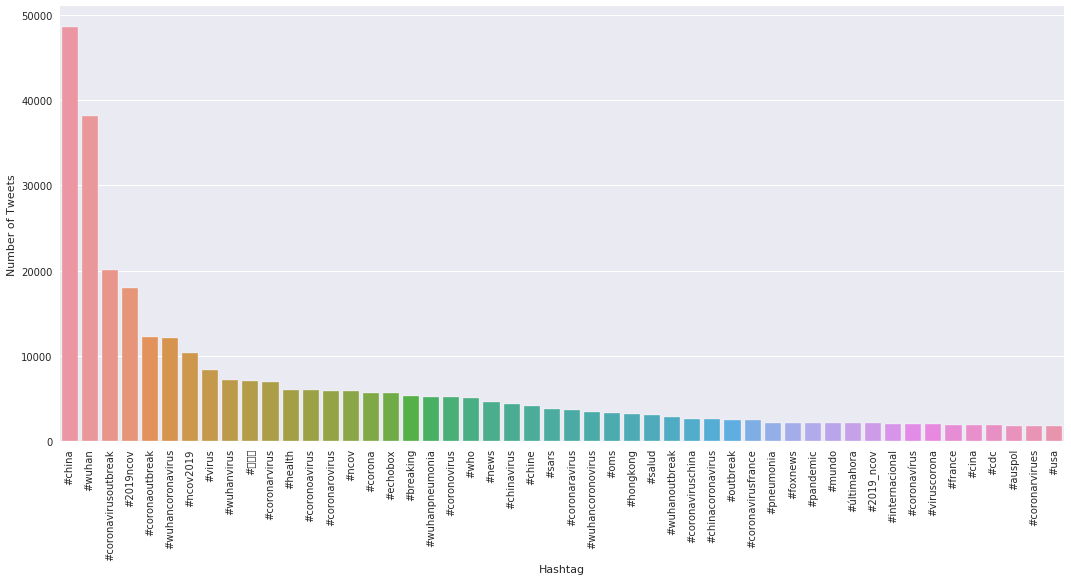

In [132]:
plt.figure(figsize=(18,8))
l_hashtags = list(hashtags_df.hashtag)[:50]
l_hashtags_count = list(hashtags_df.hashtag_count)[:50]
fig = sns.barplot(x=l_hashtags, y=l_hashtags_count)
fig.set(xlabel='Hashtag', ylabel='Number of Tweets')
fig.set_xticklabels(labels=list(hashtags_df.hashtag), rotation=90)
plt.show()

Visualize hashtags in a worldcloud

In [133]:
# concatenate hashtags
all_hashtags = " ".join(hashtag for hashtag in l_hashtags)
hashtags_wordcloud = WordCloud(background_color="white", width=1024, height=768).generate(all_hashtags)

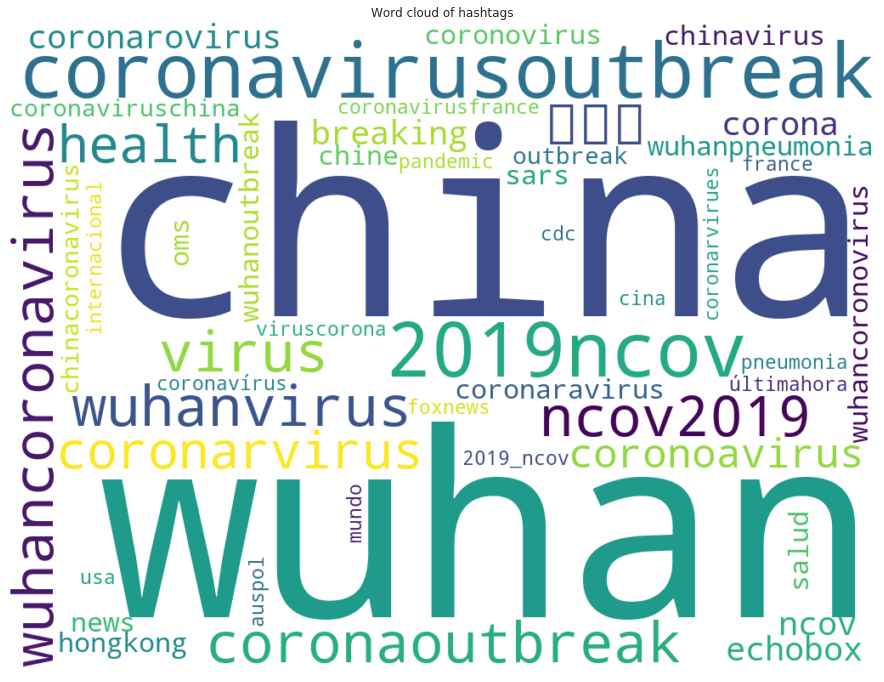

In [134]:
fig = plt.figure(1, figsize=(16, 12))
# prepare word cloud
plt.imshow(hashtags_wordcloud.recolor(random_state=3), interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud of hashtags')
# show word clouds
plt.show()

---
## Links

In [135]:
tweets_with_links = tweets[~tweets['urls'].isna()]

In [136]:
print('There are {0:,} ({1}%) tweets with links'.format(tweets_with_links.shape[0],
                                                      round(100*tweets_with_links.shape[0]/tweets.shape[0],0)))

There are 935,716 (49.0%) tweets with links


In [137]:
links = defaultdict(int)
for index, tweet in tweets_with_links.iterrows():
    tweet_links = tweet['urls'].split()
    for tweet_link in tweet_links:
        links[tweet_link] += 1

In [138]:
links_df = pd.DataFrame.from_dict({'link': list(links.keys()), 
                                   'link_count': list(links.values())})

In [139]:
links_df = links_df.sort_values('link_count', ascending=False)

In [140]:
links_df = links_df[links_df['link'].str.find('twitter.com')==-1]

In [141]:
pd.set_option('display.max_colwidth', None)
links_df.head(10)

,link,link_count
85,https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6,4931
5528,https://youtu.be/7OEqybiGdaA,1262
4786,https://www.bbc.co.uk/news/world-51318246,901
241345,"https://hsl-pnw-downloadable-files.s3.amazonaws.com/1181/the1%move_january27,2020-c7c7fe657ab9460e94fe2135c3fbaf0e.pdf",754
25714,https://www.zerohedge.com/geopolitical/did-china-steal-coronavirus-canada-and-weaponize-it,717
23499,https://patents.justia.com/patent/10130701,698
365,https://bnonews.com/index.php/2020/01/the-latest-coronavirus-cases/,676
30067,http://pbs.twimg.com/media/BG48ENgCEAAIDl9.jpg,639
4794,https://www.bbc.com/news/world-51318246,622
17933,https://www.cnn.com/2020/01/21/health/wuhan-coronavirus-first-us-case-cdc-bn/index.html,535


In [142]:
# compute domain of links
links_df['domain'] = links_df.apply(lambda row: tldextract.extract(row['link']).domain, axis=1) 

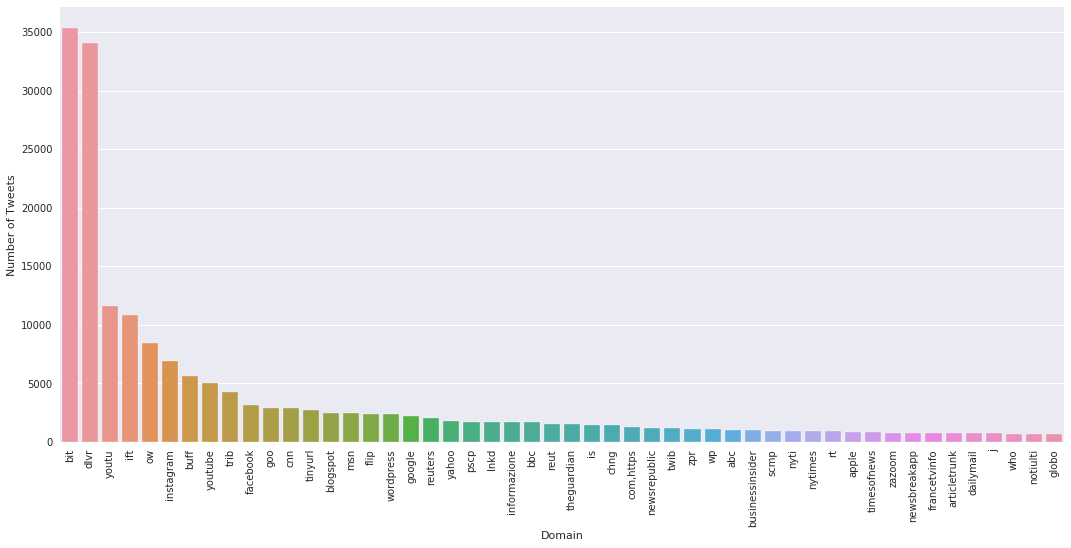

In [143]:
plt.figure(figsize=(18,8))
l_domains = list(links_df.groupby('domain').count().sort_values('link', ascending=False).head(50).index)
l_domains_count = list(links_df.groupby('domain').count().sort_values('link', ascending=False).head(50)['link'])
fig = sns.barplot(x=l_domains, y=l_domains_count)
fig.set(xlabel='Domain', ylabel='Number of Tweets')
fig.set_xticklabels(labels=l_domains, rotation=90)
plt.show()

---
## Tweets

#### Top-10 most retweeted tweets

In [144]:
tweets.sort_values('retweets', ascending=False)[['tweet_id','tweet', 'username', 'retweets']].head(10)

,tweet_id,tweet,username,retweets
731137,1221856224712495104,someone said “this is what happened when rats heard about the corona virus they dont wanna take the blame again” LMAOOOOOO pic.twitter.com/9yQs9bcfuw,emtpyvase,193402
432937,1220259934488547328,rt to save life #coronavirus pic.twitter.com/xQ8z2ihrAu,siwuol_,187737
419019,1220190098878271490,It’s not a joke . Share guys and stay safe #coronavirus pic.twitter.com/nmcciR8up3,988Patrick,95927
350432,1222650786393608192,"coronavirus has been racialised as a ""chinese"" illness and for this reason chinese people, regardless of their proximity to wuhan are being treated like carriers of the virus. similar to how ebola was subtly touted as an ""african"" illness. https:// twitter.com/Blayofficial/s tatus/1222648026663178240 …",helloalegria,82975
1656860,1220969695441932289,How to wear a mask #coronavirus pic.twitter.com/O71CjIZiWx,menumpahkan,82771
1335599,1222895918627749890,Father can’t touch his little baby as he is infected with the Corona virus ... The baby’s face tho.. pic.twitter.com/UxQxwy7DUF,Huh_My_Rahhhhh,72441
870633,1221393488413151233,the coronavirus outbreak doesn’t give u the right to be racist & xenophobic towards asian people,ughgeo,66646
1737700,1221122168043360256,2020 so far; - “world war 3” - iran plane crash - australian bushfires - volcanic eruptions - earthquake in indonesia - jakarta flood - wuhan coronavirus outbreak these happened within a month and we got 11 months to go pic.twitter.com/xZK4g3Z3JY,aminsyafee,56241
122553,1222366003071315968,Just reminding you that the coronavirus doesn’t give you an excuse to be a dick to Asian people.,SimuLiu,50161
564425,1219285703798022147,"BREAKING NEWS: This is not a scene from some apocalyptic horror movie, this is a #coronavirus outbreak in China. The SARS like virus has already spread to four countries and infected more than 1700 people. US airports are monitored. Be on alert, stay safe! pic.twitter.com/PIc7NYvsGO",howroute,48626


#### Most retweeted tweet

In [124]:
tweet_html = ("""
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">someone said “this is what happened when rats heard about the corona virus they dont wanna take the blame again” LMAOOOOOO <a href="https://t.co/9yQs9bcfuw">pic.twitter.com/9yQs9bcfuw</a></p>&mdash; night owl (@emtpyvase) <a href="https://twitter.com/emtpyvase/status/1221856224712495104?ref_src=twsrc%5Etfw">January 27, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
"""
)
Tweet(tweet_html)

#### Top-10 most liked tweets

In [145]:
tweets.sort_values('favorites', ascending=False)[['tweet_id','tweet', 'username' , 'favorites']].head(10)

,tweet_id,tweet,username,favorites
731137,1221856224712495104,someone said “this is what happened when rats heard about the corona virus they dont wanna take the blame again” LMAOOOOOO pic.twitter.com/9yQs9bcfuw,emtpyvase,676765
350432,1222650786393608192,"coronavirus has been racialised as a ""chinese"" illness and for this reason chinese people, regardless of their proximity to wuhan are being treated like carriers of the virus. similar to how ebola was subtly touted as an ""african"" illness. https:// twitter.com/Blayofficial/s tatus/1222648026663178240 …",helloalegria,266056
774300,1221920033800060928,"coronavirus , Kobe, now this. bad luck really does come in 3’s https:// twitter.com/russdiemon/sta tus/1220761977297022978 …",Grandpa,222112
1473345,1222999243981455361,"Your racist jokes about dying of coronavirus are all so tired. The flu killed 80,000 ppl in the US in 2018 alone, but I guess you’re not worried about that since it’s not racialized as carried by dirty orientals the way coronavirus is",catcontentonly,196414
870633,1221393488413151233,the coronavirus outbreak doesn’t give u the right to be racist & xenophobic towards asian people,ughgeo,193415
122553,1222366003071315968,Just reminding you that the coronavirus doesn’t give you an excuse to be a dick to Asian people.,SimuLiu,180055
364888,1222669997320728576,PSA for everyone freaking out about this coronavirus : A country that YouTubed itself into a 21st Century measles outbreak does not get to talk any shit about anyone else's health practices.,ElliottKaybooks,137691
1480013,1223004106408833025,"Working closely with China and others on Coronavirus outbreak. Only 5 people in U.S., all in good recovery.",realDonaldTrump,137587
432937,1220259934488547328,rt to save life #coronavirus pic.twitter.com/xQ8z2ihrAu,siwuol_,130641
1335599,1222895918627749890,Father can’t touch his little baby as he is infected with the Corona virus ... The baby’s face tho.. pic.twitter.com/UxQxwy7DUF,Huh_My_Rahhhhh,129785


### Fake news

Keywords about fake news related to the topic were extracted from [here](https://www.who.int/es/emergencies/diseases/novel-coronavirus-2019/advice-for-public/myth-busters). This analysis is a working-in-progress.

In [146]:
fake_news_keywords = ['mosquito', 'orina', 'urine', 'frio', 'nieve', \
                      'cold', 'snow', 'cocaine', 'cocaina', \
                      'objetos', 'billetes', 'monedas', 'objects', \
                      'coins', 'eigth meters', 'ocho metros', \
                      'ultravioleta', 'ultraviolet', 'alcohol', 'cloro', \
                      'chlorine', 'letter', 'package', 'carta', 'paquete', \
                      'neumonía', 'pneumonia', 'nariz', 'nose', 'ajo',
                      'garlic', 'aceite de sésamo', 'sesame oil', \
                      'antibióticos', 'antibiotics']

In [147]:
tweets[tweets['tweet'].str.find('vacine')!=-1][['tweet_id', 'username', 'tweet']].head(50)

,tweet_id,username,tweet
108997,1222347236371202048,_motyr,"o coronavírus na verdade é uma invenção dos comunistas chineses pra venderem uma vacina que na verdade vai implantar nanochips pra controlar as pessoas e espalhar o comunismo pelo globo capitalistas, amantes dos EUA e apoiadores do veio da Havan, não se vacinem compartilhe!"
111388,1222350521140502535,joao_alvz,Mas sarampo eu pelo menos vacinei kkk agora o coronavirus misericordia
112559,1222352048043298816,Magni5icat,Johnson & Johnson is 'confident' it can make a coronavirus vacine https:// mol.im/a/7935559
201624,1222488528547872769,Pravduh15,"With ~6K reported cases of coronavirus and an official death toll of 132, the CV sounds more like the flu. In times like these, society collectively worries about vaccines. Did you know that this flu season the flu killed 8,200 & hosp. 140,000? #coronarvirues #vacine #flu"
204465,1222492177164656641,hellenvelho,Vocês estão tão preocupados com o coronavírus mas não se esqueçam do Sarampo e da Febre Amarela kkkkkkk Se vacinem! Obrigada
267734,1222558582513848320,SilasLafaiete,Estou 100% imune... Já me vacinei!!! #corona #coronavirus #quartafeira #vidaquesegue #silaslafaiete #Twitter pic.twitter.com/YYnGZV8J0v
273440,1222563648767496193,spreadthenewsgh,Billionaire and CEO of ALIBABA Jack Ma donates a huge amount to help develop coronavirus vacine https:// amp.cnn.com/cnn/2020/01/29 /business/jack-ma-coronavirus-vaccine/index.html?__twitter_impression=true …
331729,1222628475892355079,rsbellmedia,Johnson & Johnson is 'confident' it can make a coronavirus vacine https:// buff.ly/2RA6mrQ
337578,1222635312955957254,MKussunoki,"Se desenvolverem vacina para prevenir infecção por coronavirus , por favor antivaciners deixa tudo pra nós"
367495,1223166702940090370,WORK4INDIA2020,"Cure is no where near to discovery, leave alone developing a vacine and the vacine reaching a developing country to be administered. Chinese are travelling faster than vacine. Tge estimates for the number of deaths and infected is bang on target."


---
## Geolocalized Tweets

In [148]:
tweets_with_geo = tweets[~tweets['geo'].isna()]

In [149]:
print('There are {0} tweets with geolocalization information'.format(tweets_with_geo.shape[0]))

There are 0 tweets with geolocalization information


## TODO:

1. Analyze language of tweets
2. Topic modeling of tweets
3. Most frequent words in tweets
4. Sentiment analysis of tweets
5. Geolocalize tweets
6. Analyze whether text of tweets contains information about fake news of coronavirus
7. Check quality of youtube videos shared on tweets. Example of papers that might be interesting to check in relation to assessing the quality of youtube videos
-- [A Quality Assessment of Cardiac Auscultation Material on YouTube](https://onlinelibrary.wiley.com/doi/full/10.1002/clc.22080)-- [Identifying Measures Used for Assessing Quality of YouTube Videos with Patient Health Information: A Review of Current Literature](https://www.i-jmr.org/2013/1/e6/)
-- [YouTube as a source of patient information on gallstone disease](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3983464/)